
# 🚗 Cars Dataset — Linear Regression (Step-by-Step, Beginner Friendly)
*Generated on 2025-09-12 03:29:55*

This notebook teaches **Linear Regression** with a Cars dataset in **small, easy steps**.  
Each step ends with a short **📝 TODO** so you can practice.

What you'll do:
1) Download + load the dataset (via **gdown**)  
2) Inspect + clean data (simple)  
3) Univariate plots (histograms)  
4) Single-variable Linear Regression (fit + plot)  
5) Multi-variable Linear Regression (fit + metrics)  
6) Diagnostic plots (residuals)  
7) Polynomial features + **GridSearchCV** to find the **best degree**  
8) Brief coefficient interpretation


## 0) Setup

In [4]:

#@title Install & import (safe to re-run)
import sys, subprocess

def pip_install(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=False)

pip_install("gdown>=5.1")
pip_install("pandas>=1.5")
pip_install("numpy>=1.23")
pip_install("matplotlib>=3.7")
pip_install("scikit-learn>=1.3")

import gdown, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## 1) Download & Load the Dataset

In [33]:

#@title Download CSV via gdown
GDOWN_ID = "1bwRmKkPwmLKiqOgQ_LnKH0Vsc3mJKmVR"  # provided ID
OUTPUT_CSV = "cars.csv"

if not os.path.exists(OUTPUT_CSV):
    url = f"https://drive.google.com/uc?id={GDOWN_ID}"
    gdown.download(url, OUTPUT_CSV, quiet=False)
else:
    print("Found existing file:", OUTPUT_CSV)

df = pd.read_csv(OUTPUT_CSV)
print("✅ Loaded:", df.shape)
df.head()
len(df.columns)


Found existing file: cars.csv
✅ Loaded: (19820, 18)


18


### 📝 TODO
- Skim the first few rows above. What looks like a good **target** (y) for prediction (e.g., `mpg`, `price`)?

Ans  : Price is possible prediction



## 2) Quick Inspect & Simple Cleaning

In [6]:

print("Columns:", list(df.columns))
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

df.columns = [c.strip().replace(" ", "_") for c in df.columns]
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
print("\nDropped duplicates:", before - df.shape[0])

num_cols = df.select_dtypes(include=np.number).columns

before = len(df)
df = df[(df[num_cols] >= 0).all(axis=1)]
after = len(df)

print(f"Removed {before - after} rows with negative numbers.")
print("Shape after cleaning:", df.shape)




Columns: ['selling_price', 'year', 'km_driven', 'mileage', 'engine', 'max_power', 'age', 'make', 'model', 'Individual', 'Trustmark Dealer', 'Diesel', 'Electric', 'LPG', 'Petrol', 'Manual', '5', '>5']

Data types:
 selling_price       float64
year                float64
km_driven             int64
mileage             float64
engine              float64
max_power           float64
age                 float64
make                 object
model                object
Individual            int64
Trustmark Dealer      int64
Diesel                int64
Electric              int64
LPG                   int64
Petrol                int64
Manual                int64
5                     int64
>5                    int64
dtype: object

Missing values per column:
 selling_price       0
year                0
km_driven           0
mileage             0
engine              0
max_power           0
age                 0
make                0
model               0
Individual          0
Trustmark Dealer   


### 📝 TODO
- If you see obvious bad rows (e.g., impossible negative values), write one **extra line** to filter them out.

Ans :
- Duplicates can bias the model; safe to drop.  
- Many car attributes (e.g., `weight`, `horsepower`, `displacement`) **should not be negative**.  
- Optional: mild outlier trimming via **IQR** if plots show extreme points skewing the fit.


## 3) Choose Target and Features (Keep it Simple)

In [7]:
# 👉 Target (already chosen earlier)
TARGET = "selling_price"

# Numeric predictors only
numeric_cols = [c for c in df.select_dtypes(include=np.number).columns if c != TARGET]

print("Target:", TARGET)
print("Numeric features (first 6):", numeric_cols[:6])

# Drop rows with NA in predictors or target
data_mv = df[numeric_cols + [TARGET]].dropna().copy()

X = data_mv[numeric_cols].values
y = data_mv[TARGET].values

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Target: selling_price
Numeric features (first 6): ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'age']



### 📝 TODO
- If you prefer different features, create a **manual list**, e.g.  
  `numeric_cols = ['horsepower','weight','displacement','acceleration']` (only if those exist).

No selling price is my selected target so the same feautures will be used further


## 4) Univariate Plots (Matplotlib)

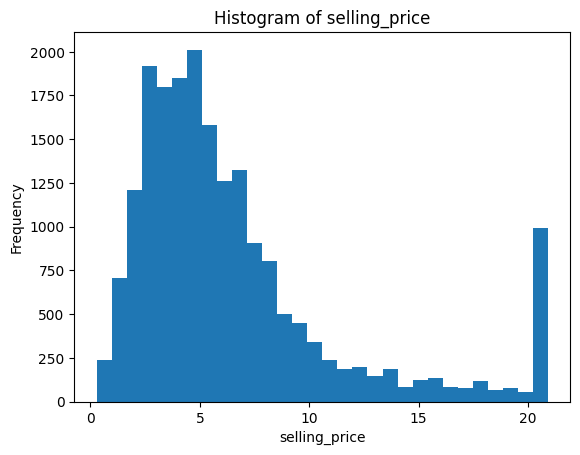

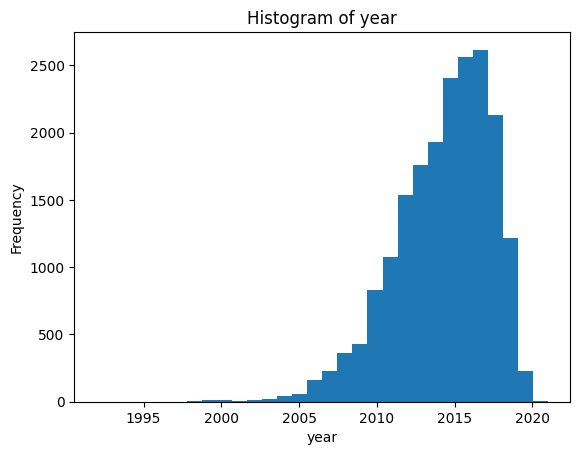

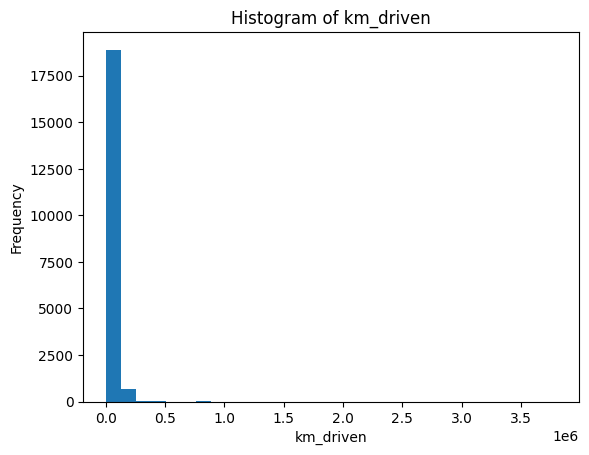

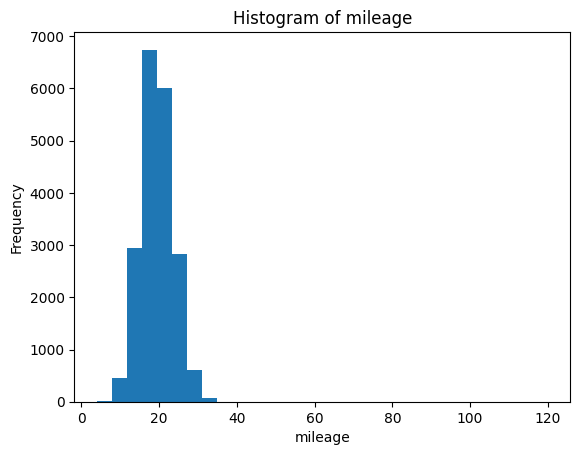

In [8]:
import matplotlib.pyplot as plt

# Target histogram
plt.figure()
df[TARGET].plot(kind='hist', bins=30, title=f"Histogram of {TARGET}")
plt.xlabel(TARGET); plt.ylabel("Frequency")
plt.show()

# Up to 3 numeric features
for col in numeric_cols[:3]:
    plt.figure()
    df[col].plot(kind='hist', bins=30, title=f"Histogram of {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.show()



### 📝 TODO
- Looking at the histograms, note any skewed variables or outliers.

Ans:

- histogram of selling price looks a bit of right skewed and outliers too

- histogram of year is slightly left skewed but looks normal

- histogram of km_driven doesnt specifying anything that means almost the values are same

- histogram of mileague looks to be a perfect bell curve so it is in normal distribution


## 5) Single-Variable Linear Regression

Feature: max_power
Coefficient: 3.77726630106161
Intercept: 6.575908483596131
R^2 (test): 0.55221382943163


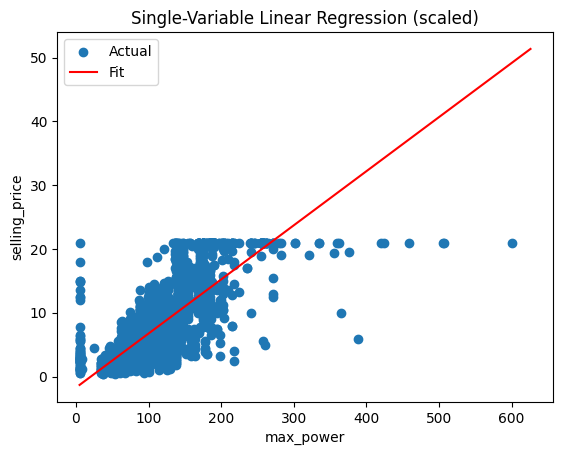

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

FEATURE_X = "max_power"  # choose a feature here

X = df[[FEATURE_X]].dropna().values
y = df[TARGET].dropna().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe_1v = Pipeline([
    ("scaler", StandardScaler()),
    ("lin", LinearRegression())
])

pipe_1v.fit(X_train, y_train)
y_pred = pipe_1v.predict(X_test)

print("Feature:", FEATURE_X)
print("Coefficient:", pipe_1v.named_steps["lin"].coef_[0])
print("Intercept:", pipe_1v.named_steps["lin"].intercept_)
print("R^2 (test):", r2_score(y_test, y_pred))

# Scatter + line
import numpy as np
plt.figure()
plt.scatter(X_test, y_test, label="Actual")
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
y_line = pipe_1v.predict(x_line)
plt.plot(x_line, y_line, label="Fit", color="red")
plt.xlabel(FEATURE_X); plt.ylabel(TARGET)
plt.title("Single-Variable Linear Regression (scaled)")
plt.legend()
plt.show()



### 📝 TODO
- Change `FEATURE_X` to a different column and re-run.
- Does the line slope match your intuition about the relationship?

ANS:

selecting max_power as feauture giving highest possible R2 score among all othere feautures

## 6) Multi-Variable Linear Regression (Simple)

In [16]:
lin_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lin", LinearRegression())
])

lin_pipe.fit(X_train, y_train)
y_pred = lin_pipe.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.3f}")
print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2:  {r2:.3f}")


MAE:  1.609
MSE:  5.627
RMSE: 2.372
R^2:  0.739



### 📝 TODO
- Remove one weak feature from `numeric_cols` and see how metrics change.
- Add a different feature and compare.


## 7) Diagnostic Plots (Residuals)

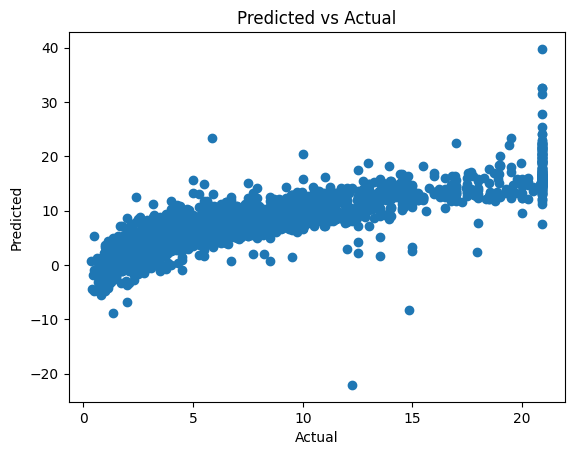

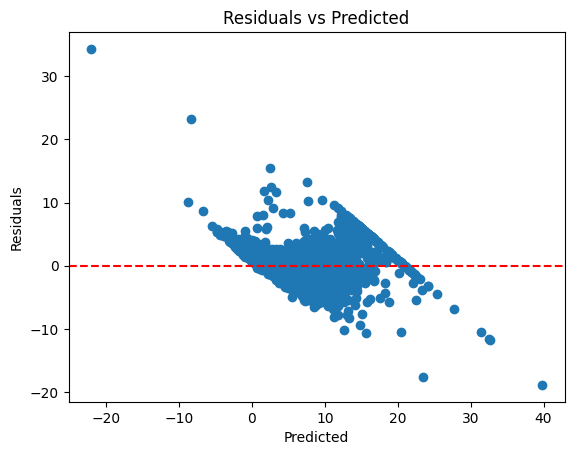

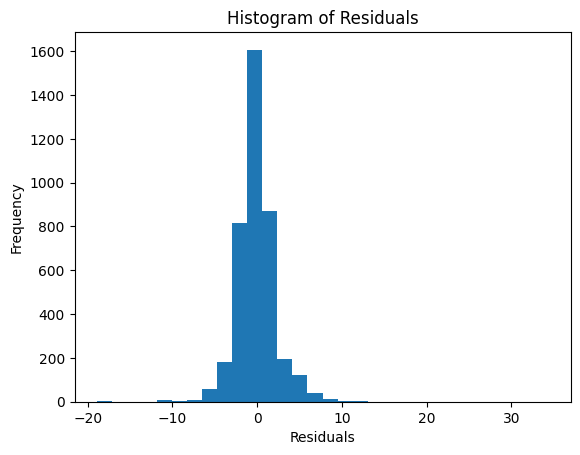

In [17]:
residuals = y_test - y_pred

# Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()

# Residuals vs Predicted
plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Predicted"); plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

# Histogram of residuals
plt.figure()
pd.Series(residuals).plot(kind="hist", bins=30, title="Histogram of Residuals")
plt.xlabel("Residuals")
plt.show()



### 📝 TODO
- Do residuals look roughly centered around 0 and evenly spread?
- If not, which assumption might be violated?

Ans

 Yes Residual formed perfect bell curve indicating normal distribution hence there are roughly centered around 0

## 8) Polynomial Features + Grid Search for Best Degree


Even though it's called "polynomial regression", it's still **linear regression** applied to **polynomially-expanded features**.
We'll try degrees **1 to 5** on a **single predictor** and pick the degree with the best cross-validated **R²**.


Best params: {'lin__fit_intercept': True, 'poly__degree': 7}
Best CV R^2: 0.6548855554959687


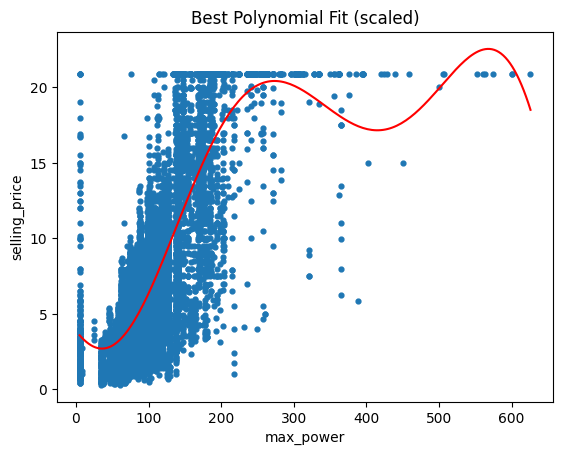

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

FEATURE_X = "max_power"  # try others too

poly_data = df[[FEATURE_X, TARGET]].dropna().copy()
X = poly_data[[FEATURE_X]].values
y = poly_data[TARGET].values

pipe_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("lin", LinearRegression())
])

param_grid = {
    "poly__degree": range(1, 9),
    "lin__fit_intercept": [True, False]
}

grid = GridSearchCV(pipe_poly, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV R^2:", grid.best_score_)

best_model = grid.best_estimator_

# Plot best curve
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
y_line = best_model.predict(x_line)

plt.figure()
plt.scatter(X, y, s=12)
plt.plot(x_line, y_line, color="red")
plt.xlabel(FEATURE_X); plt.ylabel(TARGET)
plt.title("Best Polynomial Fit (scaled)")
plt.show()



### 📝 TODO
- Change the degree range (e.g., 1–8) and re-run. Does performance keep improving?
- Try a different `FEATURE_X`.

Got 0.6 R2 score as highest possible at degree 6 and this is highest possible score brought up by feature **max_power**



## 9) Interpreting Coefficients (Multi-Variable Model)

In [19]:
coef_df = pd.DataFrame({
    "feature": numeric_cols,
    "coefficient": lin_pipe.named_steps["lin"].coef_
})

coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df.sort_values("abs_coef", ascending=False, inplace=True)
coef_df.drop(columns=["abs_coef"], inplace=True)

coef_df.head(10)


,feature,coefficient
4,max_power,2.159713
12,Manual,-1.016179
0,year,0.825301
5,age,-0.825301
11,Petrol,-0.717036
2,mileage,-0.640741
3,engine,0.458322
1,km_driven,-0.356142
8,Diesel,0.274019
14,>5,-0.186947



### 📝 TODO
- Which features have the largest (absolute) coefficients?
- Do the signs (+/-) match your intuition?

Ans:
max_power has highest absolute cofficients
Postive indicates increase in selling price(target) on contrast negative indicates decrease in selling price





## 10) Linear Regression — Quick Assumptions Checklist
- **Linearity**: Relationship between predictors and target is roughly linear.
- **Independence**: Errors are independent.
- **Homoscedasticity**: Residuals have constant variance.
- **Normality (for inference)**: Residuals are roughly normal.
- **No perfect multicollinearity**: Avoid duplicate/linearly dependent features.



## 11) Assumption Checks — Code You Can Run
We'll check the classic linear regression assumptions using simple, readable code:
- **Linearity & Homoscedasticity:** residuals vs predicted plot
- **Normality of residuals:** Q–Q plot and Shapiro–Wilk test
- **Independence of errors:** Durbin–Watson statistic
- **Multicollinearity:** Variance Inflation Factor (VIF)


In [20]:

#@title Install test libs (statsmodels) if needed
import sys, subprocess
def pip_install(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=False)

try:
    import statsmodels
except:
    pip_install("statsmodels>=0.14")
    import statsmodels

from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# NOTE: This cell assumes you've already run the multi-variable model section
# so that y_test, y_pred, X_train, X_test, numeric_cols, TARGET are defined.
# If not, re-run sections 6 and 7.


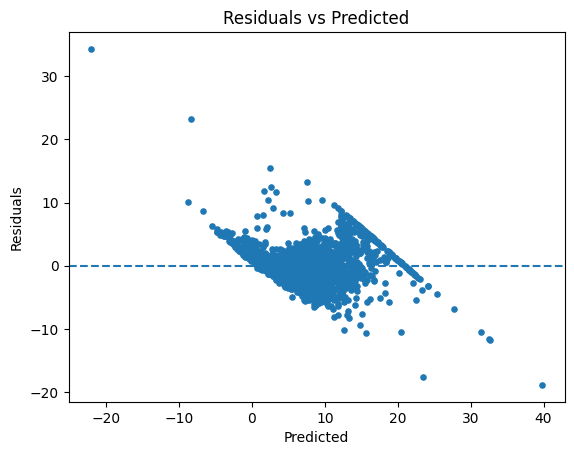

🧐 Look for: no obvious curve/pattern; spread roughly constant across x-axis.


In [21]:

# 11.1 Linearity & Homoscedasticity (visual)
# Residuals vs Predicted should look like a random cloud around 0 (no pattern / fanning)

residuals = y_test - y_pred

plt.figure()
plt.scatter(y_pred, residuals, s=14)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

print("🧐 Look for: no obvious curve/pattern; spread roughly constant across x-axis.")


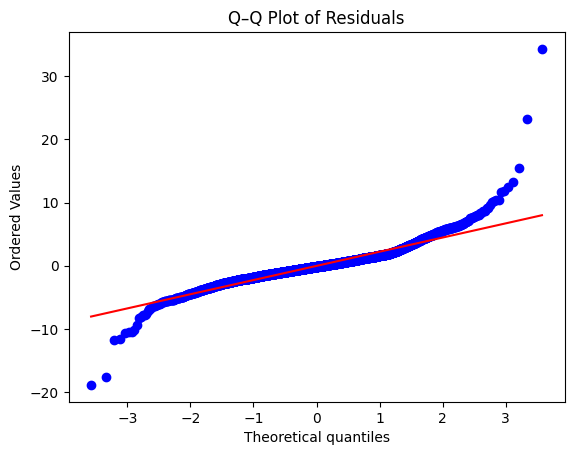

Shapiro–Wilk: statistic=0.897, p-value=1.89e-45
Rule of thumb: p-value > 0.05 suggests residuals are close to normal (for inference).


In [22]:

# 11.2 Normality of residuals: Q–Q plot + Shapiro–Wilk test
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals")
plt.show()

sh_stat, sh_p = stats.shapiro(residuals)
print(f"Shapiro–Wilk: statistic={sh_stat:.3f}, p-value={sh_p:.3g}")
print("Rule of thumb: p-value > 0.05 suggests residuals are close to normal (for inference).")


In [23]:

# 11.3 Independence of errors: Durbin–Watson (≈2 is good; <1 or >3 indicates strong autocorrelation)
dw = durbin_watson(residuals)
print(f"Durbin–Watson statistic = {dw:.3f}")
print("Guideline: ~2 means uncorrelated; much below 2 ⇒ positive autocorrelation; much above 2 ⇒ negative autocorrelation.")


Durbin–Watson statistic = 1.968
Guideline: ~2 means uncorrelated; much below 2 ⇒ positive autocorrelation; much above 2 ⇒ negative autocorrelation.


In [24]:

# 11.4 Homoscedasticity formal test: Breusch–Pagan
# Use original predictors (X_test). Add constant for the test design matrix.

X_bp = sm.add_constant(pd.DataFrame(X_test, columns=numeric_cols))
bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X_bp)
print(f"Breusch–Pagan: stat={bp_stat:.3f}, p-value={bp_p:.3g}")
print("Rule of thumb: p-value > 0.05 ⇒ no strong evidence of heteroscedasticity.")


Breusch–Pagan: stat=2066.803, p-value=0
Rule of thumb: p-value > 0.05 ⇒ no strong evidence of heteroscedasticity.


In [26]:

# 11.5 Multicollinearity: VIF (on training predictors)
X_vif = pd.DataFrame(X_train, columns=numeric_cols).dropna()
X_vif_const = sm.add_constant(X_vif, has_constant='add')

vif_vals = []
for i, col in enumerate(X_vif_const.columns):
    if col == 'const':
        continue
    vif_vals.append({"feature": col, "VIF": variance_inflation_factor(X_vif_const.values, i)})

vif_df = pd.DataFrame(vif_vals).sort_values("VIF", ascending=False)
vif_df


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,year,inf
5,age,inf
11,Petrol,17.499619
8,Diesel,16.610718
14,>5,13.024664
13,5,11.876077
3,engine,6.312178
4,max_power,4.063214
2,mileage,3.118588
12,Manual,1.538234



### 📝 TODO
- If **Breusch–Pagan p < 0.05**, try transforming a skewed feature (e.g., `np.log1p(x)`) and re-fit.  
- If **Shapiro p < 0.05**, consider outliers or feature transforms.  
- If **VIF > 10** for a feature, try removing it or combining highly correlated features.  
- If **Durbin–Watson** is far from 2 (time-indexed data), try adding lag features or using time-series models.


In [28]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression

# Example data
np.random.seed(42)
n = 100
X = pd.DataFrame({
    "x1": np.random.exponential(scale=10, size=n),   # skewed
    "x2": np.random.normal(50, 10, size=n),
    "x3": np.random.normal(30, 5, size=n),
})
y = 5 + 0.3 * X["x1"] + 0.6 * X["x2"] + np.random.normal(0, 3, n)

# Fit model
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
residuals = model.resid
print(model.summary())

# --- 1. Breusch–Pagan Test (Homoscedasticity) ---
bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X_const)
print("\nBreusch–Pagan p-value:", bp_p)

if bp_p < 0.05:
    print("Heteroscedasticity detected. Trying log transform on skewed features...")
    # Check skewness and transform highly skewed features
    skewed = X.skew().abs()
    for col in skewed.index:
        if skewed[col] > 1:   # threshold for skewness
            X[col] = np.log1p(X[col])   # log1p handles zeros
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    print(model.summary())

# --- 2. Shapiro–Wilk Test (Normality of residuals) ---
shapiro_stat, shapiro_p = shapiro(residuals)
print("\nShapiro–Wilk p-value:", shapiro_p)

if shapiro_p < 0.05:
    print("Residuals not normal. Consider removing outliers or feature transforms...")
    # Example: remove extreme outliers in residuals
    z_scores = (residuals - residuals.mean()) / residuals.std()
    mask = z_scores.abs() < 3   # keep only |z| < 3
    X = X[mask]
    y = y[mask]
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    print(model.summary())

# --- 3. VIF (Multicollinearity) ---
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
print("\nVIF:\n", vif_data)

if (vif_data["VIF"] > 10).any():
    print("High multicollinearity detected. Dropping the worst feature...")
    worst = vif_data.sort_values("VIF", ascending=False).iloc[0]["feature"]
    X = X.drop(columns=[worst])
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    print(model.summary())

# --- 4. Durbin–Watson Test (Autocorrelation of residuals) ---
dw = durbin_watson(residuals)
print("\nDurbin–Watson:", dw)

if dw < 1.5 or dw > 2.5:  # rule of thumb
    print("Autocorrelation detected. Try adding lag features (time-series)...")
    # Example lag feature (if X has time-index)
    X["x1_lag1"] = X["x1"].shift(1).fillna(X["x1"].mean())
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     206.6
Date:                Sun, 14 Sep 2025   Prob (F-statistic):           9.72e-42
Time:                        12:17:49   Log-Likelihood:                -228.52
No. Observations:                 100   AIC:                             465.0
Df Residuals:                      96   BIC:                             475.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8035      1.947      2.981      0.0